## Necessary Imports

In [24]:
# Python 
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn 
import sklearn
assert sklearn.__version__ >= "0.20"

# Pandas
import pandas as pd

import random

# Common imports
import numpy as np
import os
import cv2  

np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

## Load all Images into a Panda Dataframe with Labels

In [ ]:
ROOT_PATH = os.path.join("..", "datasets", "lung_images")

# Define subfolders and their corresponding labels
folders_with_labels = {
    "Benign cases": "benign",
    "Malignant cases": "malignant",
    "Normal cases": "normal",
    "Test cases": "test"
}

# Initialize lists to store image data and labels
image_data = []
labels = []

# Iterate through each folder and load images with labels
for folder, label in folders_with_labels.items():
    folder_path = os.path.join(ROOT_PATH, "Training cases" if folder != "Test cases" else "Test cases", folder)
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Adjust based on image format
            # Load the image in grayscale (adjust if needed)
            img_path = os.path.join(folder_path, filename)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            # Store the image and its label
            image_data.append(image)
            labels.append(label)

# Convert to a DataFrame for easy manipulation
images_lung_cancer = pd.DataFrame({
    "image": image_data,
    "label": labels
})

# Display the first few rows to verify
print(images_lung_cancer.head())

                                               image   label
0  [[38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, ...  benign
1  [[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, ...  benign
2  [[38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, ...  benign
3  [[38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, ...  benign
4  [[38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, ...  benign


The images have been loaded into a 2D Pandas Dataframe, with the image being a one dimensional vector and the label being a string.

All images have been loaded in greayscale as they are black and white.

It is importaant to note that images from the Test cases folder have green boxes to indicate where the tumoras are, however, in order for this dataframe to work for the analysis, they have been loaded in as grayscale

#### Checking class distribution

In [18]:
images_lung_cancer.info()
images_lung_cancer['label'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1294 entries, 0 to 1293
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1294 non-null   object
 1   label   1294 non-null   object
dtypes: object(2)
memory usage: 20.3+ KB


label
malignant    561
normal       416
test         197
benign       120
Name: count, dtype: int64

There are a total of 1294s image, each having a label. Although, the images from the test folder have just been labeled test, without indication of the presence of a tumor and its type.

We can see that in the training cases dataset, there is a class imbalance, with 561 images indicating malignant tumors, 416 being normal images (non-tumurous) and only 120 being benign. Ideally, you want the class distribution in the training data to be equal. Oversampling techniques might be required to improve model performance.

#### Checking Image Sizes

In [19]:
def count_unique_image_sizes(df, image_column='image'):
    """
    Counts unique image sizes in a DataFrame.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing images.
        image_column (str): The name of the column with image data.
        
    Returns:
        pd.DataFrame: A DataFrame with unique sizes and their counts.
    """
    # Initialize a list to store image sizes
    image_sizes = []

    # Loop through each image in the specified column
    for image in df[image_column]:
        # Get the shape of the image (height, width)
        height, width = image.shape
        # Append the size as a tuple
        image_sizes.append((height, width))

    # Convert the list to a DataFrame for easy counting and analysis
    size_df = pd.DataFrame(image_sizes, columns=['height', 'width'])

    # Count the unique sizes
    unique_sizes = size_df.value_counts().reset_index(name='count')

    return unique_sizes

# Display dimensions and counts of the images
unique_sizes_df = count_unique_image_sizes(images_lung_cancer)
print("Unique image sizes and their counts:")
print(unique_sizes_df)


Unique image sizes and their counts:
   height  width  count
0     512    512   1230
1     512    623     31
2     512    801     28
3     768    768      3
4     331    506      1
5     404    511      1


Most images are a size of 512x512 pixels. There are 64 images that have different dimensions and need to be resized in order to train the models.

#### Normalising Image Sizes 

In [21]:
# Define the target size
target_size = (512, 512)

# Resize each image to the target size
images_lung_cancer['image'] = images_lung_cancer['image'].apply(lambda img: cv2.resize(img, target_size, interpolation=cv2.INTER_AREA))

# Display dimensions and counts of the images
unique_sizes_df = count_unique_image_sizes(images_lung_cancer)
print("Unique image sizes and their counts:")
print(unique_sizes_df)

Unique image sizes and their counts:
   height  width  count
0     512    512   1294


All images have been resized to the same dimensions: 512x512 pixels

## Data Exploration

#### Displaying images from different classes 

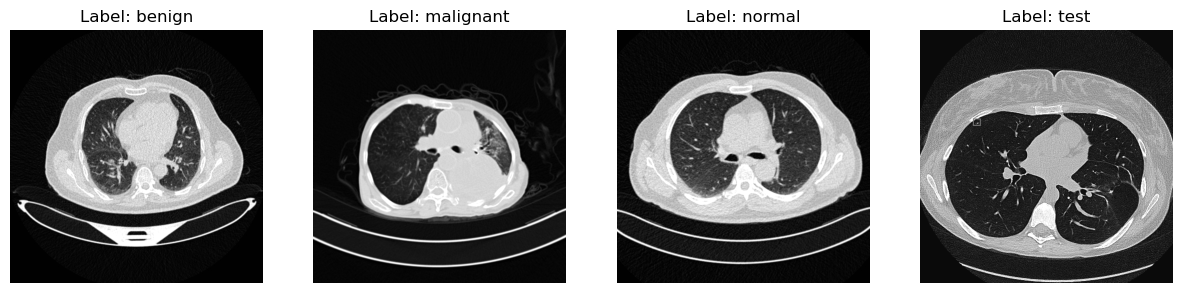

In [91]:
# Get unique labels
unique_labels = images_lung_cancer['label'].unique()

# Set up a figure with subplots arranged in a row
plt.figure(figsize=(15, 5))  # Adjust width and height as needed

for i, label in enumerate(unique_labels):
    # Filter images for the current label
    label_images = images_lung_cancer[images_lung_cancer['label'] == label]['image']
    # Randomly select one image from the filtered images
    sample_image = label_images.sample(1).values[0]
    
    # Plot the sample image in a subplot
    plt.subplot(1, len(unique_labels), i + 1)
    plt.imshow(sample_image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')  # Hide the axis

plt.show()

From displaying images from different label classes, we can conclude the following:

1. Images have different zoom. In some images the main subject (the lungs), take up almost the entire image, in other cases only a third of the image
2. Filler space differences. Some images have a light grey ring around the lungs, some images have noise, some images have an all black background.
3. Different lung sections. When the lungs are scanned, the machine images a horizontal slice of the lungs. closer to the neck the lungs cover less area and close to the belly, they cover a wider area.

All these observations could make it challenging for the model to identify consistent features across the dataset. Potentially, zoom level could be normalized and background could be masked out as a preprocessing step.

Overall, not being a professional in the field of medicine, the images from all classes look relatively similar and there are no obvious giveaways for whether it is a scan of a tumor or not. 

#### Pixel intensity distributiuon across images 

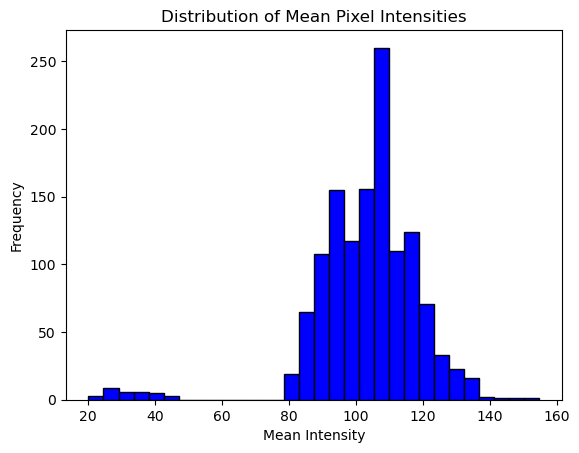

In [231]:
# Calculate mean and standard deviation of pixel intensities across all images
pixel_means = [np.mean(image) for image in images_lung_cancer['image']]
pixel_stds = [np.std(image) for image in images_lung_cancer['image']]

# Plot histogram of pixel intensity means
plt.hist(pixel_means, bins=30, color='blue', edgecolor='black')
plt.title("Distribution of Mean Pixel Intensities")
plt.xlabel("Mean Intensity")
plt.ylabel("Frequency")
plt.show()

Most images have a pixel intensity between 80 and 120, with an intensity of 110 being the most common by far. This is expected, as depending on the height of where the CT scan took place, the organs and bones cover a different area, resulting in more or less white pixels.

However, there are a few images with intensities between 20 and 40, suggesting that they are almost entirely black, which is unusual and prompts further investigation. There are also several imnages with intensities above 140, which prompts further investigation.

#### Displaying images of different intensities

To understand the abnormalities, images from the intensity ranges (20-50, 80-120, 130,160) will be displayed

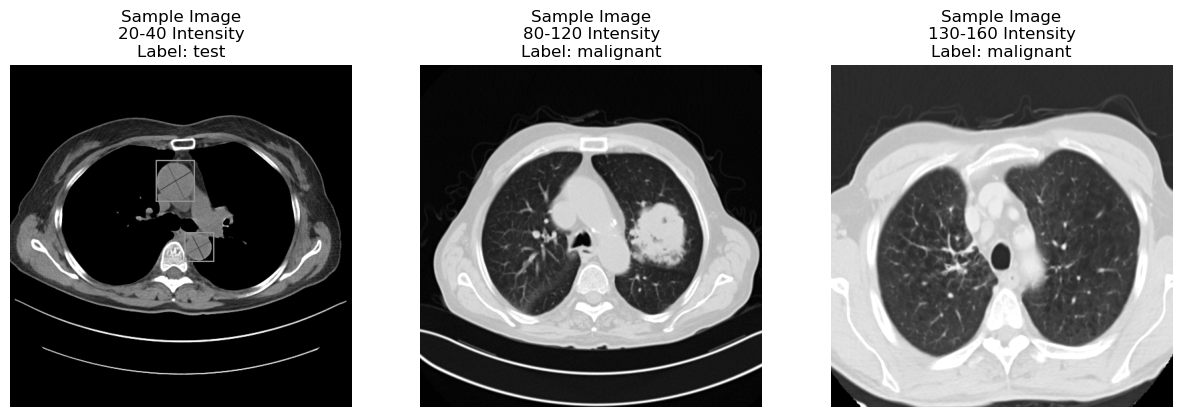

In [73]:
# Function to get a random image and its label from a specified pixel intensity range
def get_random_image_from_intensity_range(df, intensity_range):
    # Filter images based on the mean pixel intensity range
    filtered_images = df[(df['image'].map(np.mean) >= intensity_range[0]) & 
                         (df['image'].map(np.mean) <= intensity_range[1])]
    # Choose one row randomly from the filtered images
    if not filtered_images.empty:
        sample = filtered_images.sample(1).iloc[0]
        return sample['image'], sample['label']
    else:
        return None, None

# Define the intensity ranges
intensity_ranges = [(20, 40), (80, 120), (130, 160)]
titles = ["20-40 Intensity", "80-120 Intensity", "130-160 Intensity"]

# Set up a figure with three subplots in a row
plt.figure(figsize=(15, 5))
for i, intensity_range in enumerate(intensity_ranges):
    # Get a random image and its label from the specified range
    image, label = get_random_image_from_intensity_range(images_lung_cancer, intensity_range)
    if image is not None:
        plt.subplot(1, 3, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Sample Image\n{titles[i]}\nLabel: {label}")
        plt.axis('off')  # Hide the axis

plt.show()

After checking out the images, several conclusions can be drawn. All images with lower intensity values are from the test cases folder. It appears they were either scanned differently or come from a separate batch of scans, resulting in a significantly darker images. 

However, not all images with the test label are that way, as test images appear in both of the other ranges.

By running this code several times, the images with higher intensity are mostly of the malignant class, however, images from all other classes appear there as well. These images are zoomed in on the lung portion, eliminating the dark filler space around, resulting in higher values. 

Possibly, significant variation in pixel intensities and scale of the the main subject of the scan (lung) could result in poorer overall accuracy of the model. On the other side, in practice, scans come in different variations and having these cases could result in a model that generalises better to the real world.

It would be best to have one dataset where the scans have variation in intensities, and another set where the images are adjusted to have more similar intensities to see the differences in model training.

#### Important note on the images in the Test cases folder

The images inthe training folder are clearly assigned to a class: normal, benign, malignant. Images in the test folder are not assigned a specific class. Most of them have tumors and the tumor is indicated by a green box. Since this data will be used for classification, the images from the test cases folder could be unsuitable for this use and will possibly be removed from the frame for training purposes. This will also eliminate all images with lower pixel intensities. The images from the training cases folder will have to be split for training and testing purposes or for cross validation.

#### Statistical Comparison Between Classes

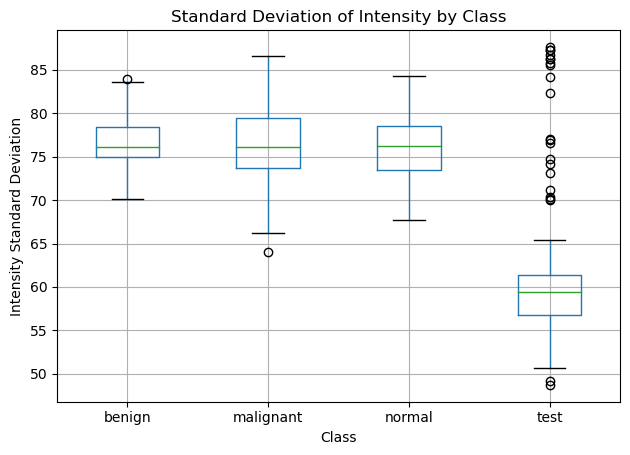

In [ ]:
# Initialize lists to store pixel intensity statistics
intensity_means = []
intensity_medians = []
intensity_stds = []
labels = []

# Calculate intensity statistics for each image
for _, row in images_lung_cancer.iterrows():
    image = row['image']
    label = row['label']
    intensity_means.append(np.mean(image))
    intensity_medians.append(np.median(image))
    intensity_stds.append(np.std(image))
    labels.append(label)

# Create a DataFrame to store the statistics and labels
intensity_df = pd.DataFrame({
    "label": labels,
    "mean_intensity": intensity_means,
    "median_intensity": intensity_medians,
    "std_intensity": intensity_stds
})

# Visualize standard deviation of pixel intensity across classes
intensity_df.boxplot(column="std_intensity", by="label")
plt.title("Standard Deviation of Intensity by Class")
plt.suptitle("")
plt.xlabel("Class")
plt.ylabel("Intensity Standard Deviation")

plt.tight_layout()
plt.show()

This plot shows that the pixel intensity (mean) is similar across the classes benign, malignant and normal. The standard deviation across these classes is also similar, with malignant class having a higher one, probably due to zoomed in images. These classes also have almost no outliers.

However, the images from the Test Cases folder has a significantly lower mean and many outliers. This is probably due to the scans with lower intensities. This gives more reason to exclude these images from training and testing

#### Class Median Image

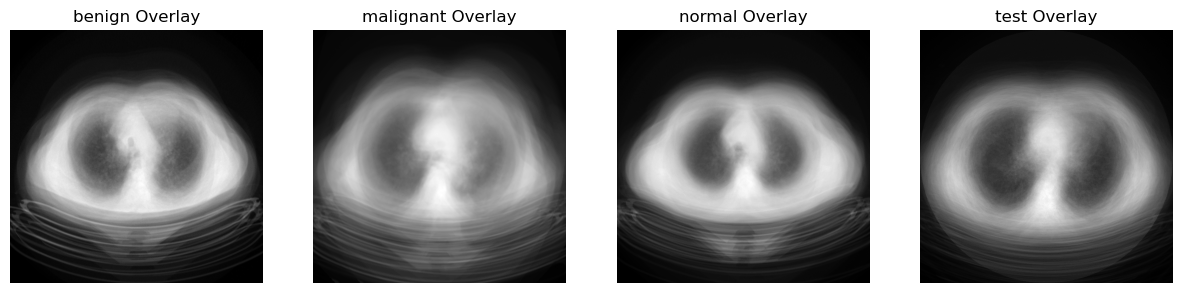

In [95]:
# Initialize a dictionary to store the average or median images for each class
class_overlay_images = {}

# Calculate the average or median image for each class
for label in images_lung_cancer['label'].unique():
    # Stack all images for the current label
    class_images = np.array([img for img in images_lung_cancer[images_lung_cancer['label'] == label]['image']])
    
    # Calculate the mean or median image
    # Uncomment one of the following lines depending on whether you want the mean or median
    overlay_image = np.mean(class_images, axis=0)  # Mean overlay
    # overlay_image = np.median(class_images, axis=0)  # Median overlay

    # Store the overlay image in the dictionary
    class_overlay_images[label] = overlay_image

# Set up a figure with subplots in a row to display the overlay images
plt.figure(figsize=(15, 5))  # Adjust width and height as needed

for i, (label, overlay_image) in enumerate(class_overlay_images.items()):
    plt.subplot(1, len(class_overlay_images), i + 1)
    plt.imshow(overlay_image, cmap='gray')
    plt.title(f"{label} Overlay")
    plt.axis('off')  # Hide the axis

plt.show()

Generating a mean image can give insight into differencees between the clasees.

Overall, the shapes look consistant over all classes. Main structures can be notices, such as a white hook shaped feature in the middle, two black ovals, which is the corssection of the lungs and the white oval surrounding the lungs. 

For the malignant class, the overall shape seems to be taller, which could be a result of coincidense, or due to larger variations in lung scans in that class. Likely, this is a result of this class having more zoomed in images, as previosly observed in the pixel intensity distribution.

#### Edge Detection Visualisation

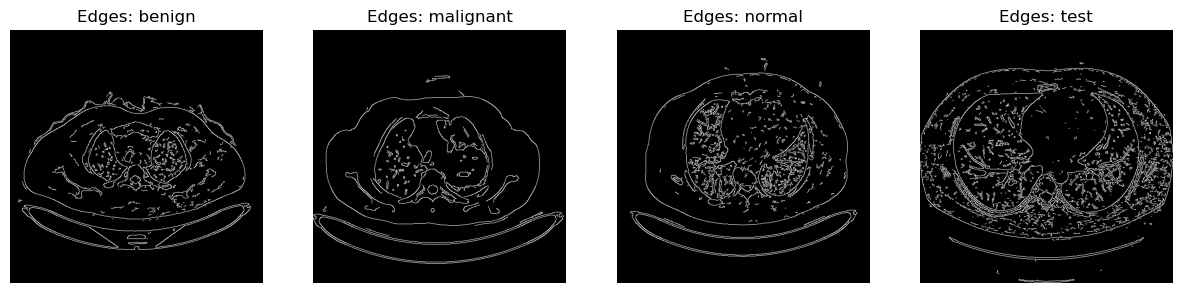

In [229]:
# Initialize a dictionary to store edge-detected images for each class
class_edge_images = {}

# Perform edge detection for each class
for label in images_lung_cancer['label'].unique():
    # Select a random image from each class
    sample_image = images_lung_cancer[images_lung_cancer['label'] == label].sample(1)['image'].values[0]
    
    # Apply Canny edge detection
    edges = cv2.Canny(sample_image, 100, 200)  # Adjust thresholds as needed

    # Store the edge-detected image
    class_edge_images[label] = edges

# Set up a figure with subplots in a row to display the edge-detected images
plt.figure(figsize=(15, 5))  # Adjust width and height as needed

for i, (label, edge_image) in enumerate(class_edge_images.items()):
    plt.subplot(1, len(class_edge_images), i + 1)
    plt.imshow(edge_image, cmap='gray')
    plt.title(f"Edges: {label}")
    plt.axis('off')  # Hide the axis

plt.show()

We can see a wide variation in the images produced after applying Cannyedge detection method:

1. Some images have few lines and and outline only the main shapes. 
2. Most images have smaller structures within and around the lungs.
3. Some images have a lot more smaller structures in and around the lungs, almost looking like a grainy texture.
4. Few images produced look like they are just covered in noise. 

None of these appear to be class specific, although I have not found any (4) cases in the malignant class. 

It would be interesting to see how images preprocessed with edge detection would affect model performance.

#### Pixel Intensity Distribution with Edge Detection

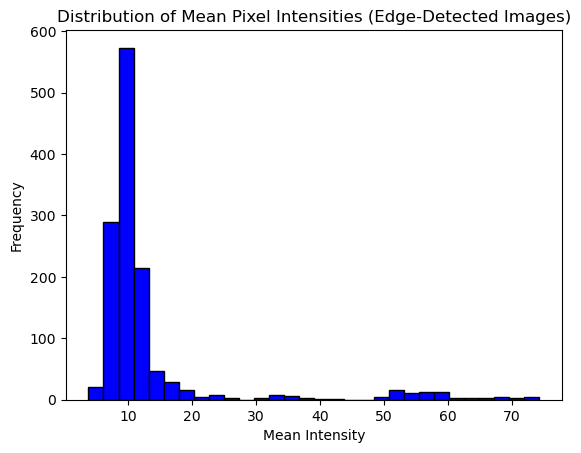

In [230]:
# Calculate pixel intensities for edge-detected images
edge_pixel_means = []

for image in images_lung_cancer['image']:
    # Apply Canny edge detection
    edges = cv2.Canny(image, 100, 200)  # Adjust thresholds if needed
    # Calculate the mean intensity of the edge-detected image
    edge_pixel_means.append(np.mean(edges))

# Plot histogram of pixel intensity means for edge-detected images
plt.hist(edge_pixel_means, bins=30, color='blue', edgecolor='black')
plt.title("Distribution of Mean Pixel Intensities (Edge-Detected Images)")
plt.xlabel("Mean Intensity")
plt.ylabel("Frequency")
plt.show()

Visualising the distribution of pixel intencity of the images processed with Canny edge detection gives more clarity and reassurance.

The vast majority of these images has an intensity of around 10, case (2)

There is a slight spike between the values of 50-60, case (4)

Even though there are images on which the edge detection algorithm results in a noise pattern, they are few. Most images processed with edge detection have clearly defined shapes and details, maling this suitable for machine learning. 

#### PCA Dimensionality Reduction


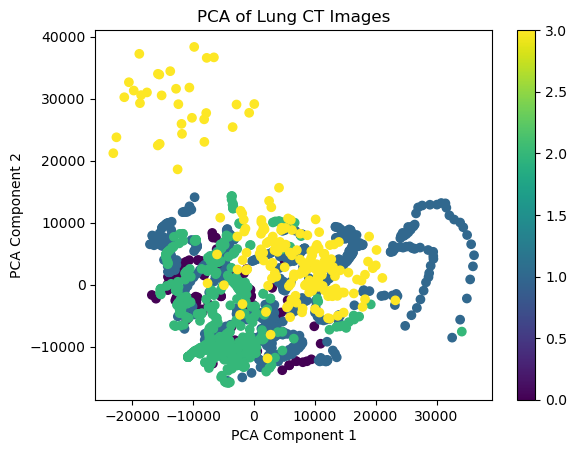

In [39]:
from sklearn.decomposition import PCA

# Flatten images and apply PCA
flattened_images = [image.flatten() for image in images_lung_cancer['image']]
pca = PCA(n_components=2)
principal_components = pca.fit_transform(flattened_images)

# Create a scatter plot of the first two principal components
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=images_lung_cancer['label'].map({'benign': 0, 'malignant': 1, 'normal': 2, 'test': 3}), cmap='viridis')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of Lung CT Images")
plt.colorbar()
plt.show()
